## Testing the Variogram methods

In [19]:
%load_ext autoreload
%autoreload 2
# %matplotlib ipympl
%matplotlib inline

from variogram.VariogramAnalysis import VariogramAnalysis
from Dataset import DatasetName, load_dataset, load_single_file
from data_preprocessing import plot_buoy_data_time_collapsed, plot_buoy_data_at_time_step

import geostatspy.geostats as geostats
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from datetime import datetime, timedelta
from ipywidgets import interact, interactive, IntSlider
import numpy as np
import os

# load data for 40 days
dataset_name = DatasetName.AREA1
data = load_dataset(dataset_name)

# dataset_name = DatasetName.AREA1
# data = load_single_file(dataset_name, file_idx=10)

# convert time axis to datetime
data["time"] = pd.to_datetime(data["time"])

# find earliest time/date and subtract from time column
earliest_date = data["time"].min()
data["time_offset"] = data["time"].apply(lambda x: (x - earliest_date).seconds//3600 + (x-earliest_date).days*24)
data["time_offset"] = data["time_offset"].astype(int)

print("\nBuoy Meta Data:")
print(f"Min time: {data['time'].min()}, max time: {data['time'].max()}")
print(f"Min lon: {data['lon'].min()}, max lon: {data['lon'].max()}")
print(f"Min lat: {data['lat'].min()}, max lat: {data['lat'].max()}\n")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Buoy Meta Data:
Min time: 2022-04-21 19:00:00, max time: 2022-06-13 17:00:00
Min lon: -139.998, max lon: -120.0
Min lat: 20.0, max lat: 30.0



## Visualise raw data spacially

IntSlider(value=0, description='Time [hrs]:', max=214)

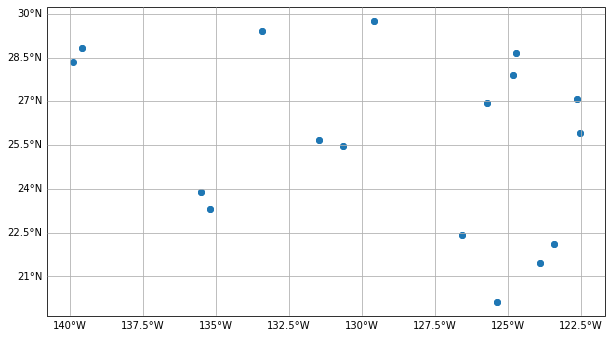

In [24]:
# visualise raw data
fig, scatter, ax = plot_buoy_data_at_time_step(data)

# Try with matplotlib
time_list = sorted(list(set(data["time_offset"].astype(int).tolist())))

time = widgets.IntSlider(
    value=0,
    min=0,
    max=time_list[-1],
    step=1,
    description="Time [hrs]:",
    disabled=False,
    continuous_update=True,
    orientation="horizontal"
)

def update(time):
    scatter.set_ydata(data[data["time_offset"] == time]["lat"])
    scatter.set_xdata(data[data["time_offset"] == time]["lon"])
    fig.canvas.draw_idle()

w = widgets.interactive(update, time=time)
display(time)

## Compute and plot variograms

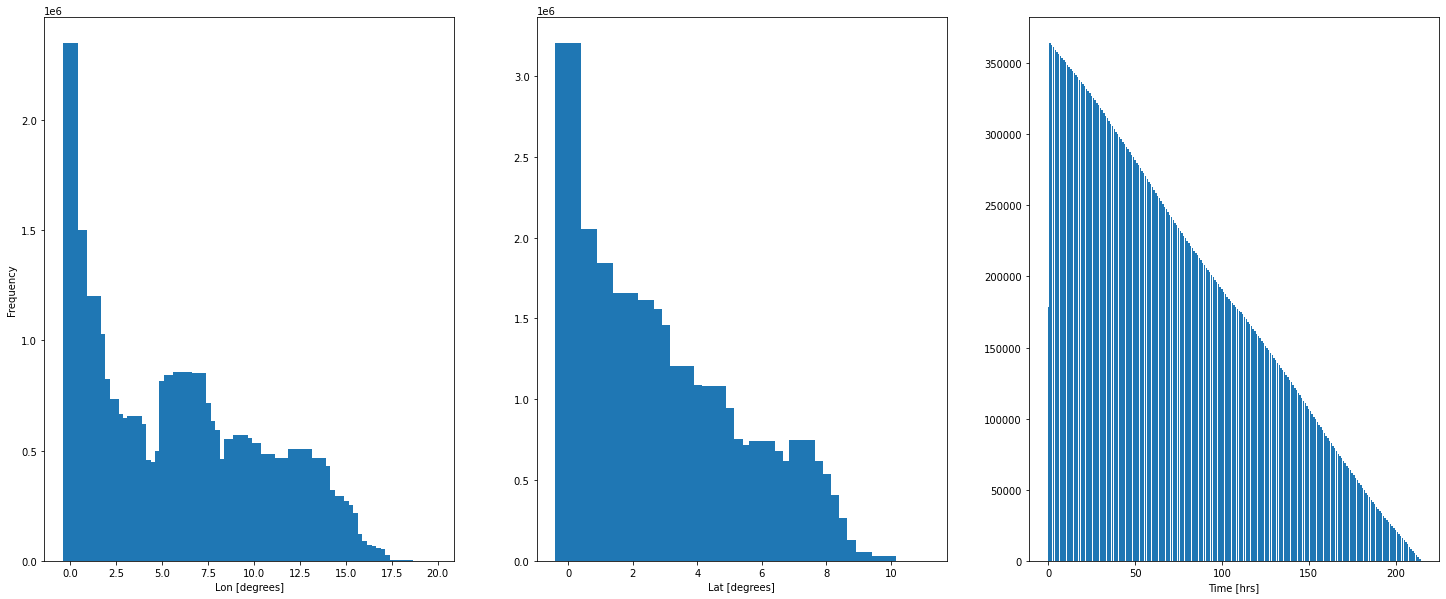

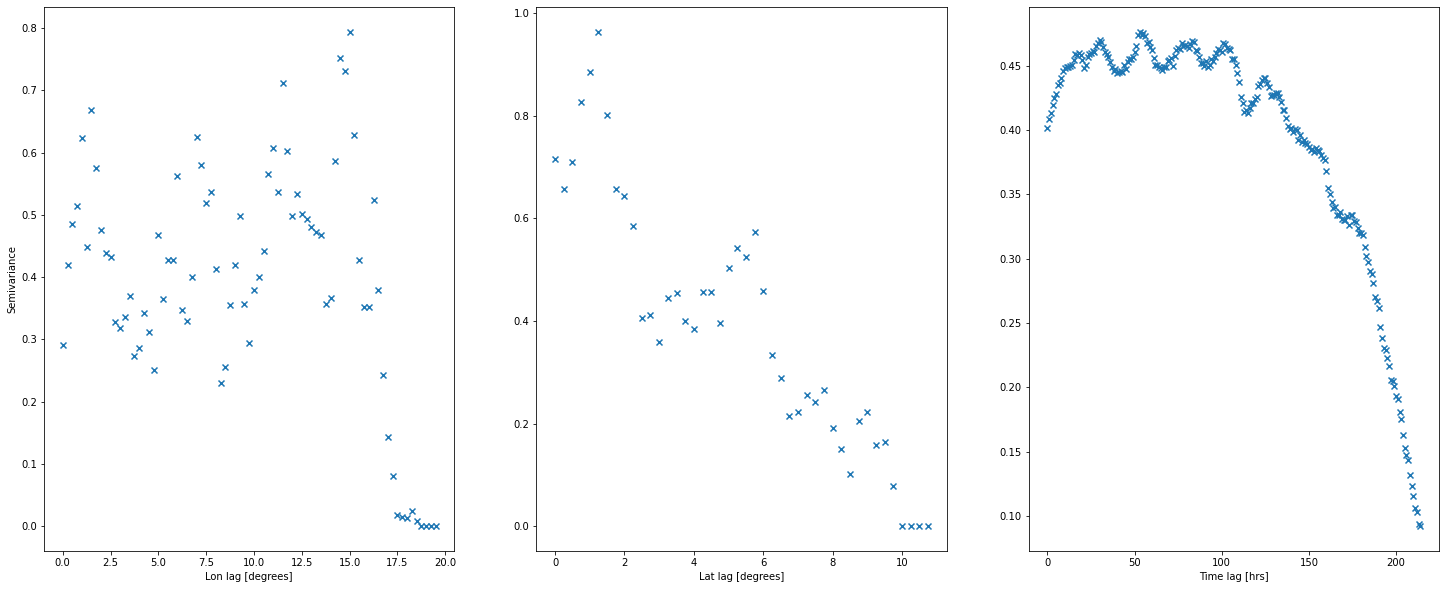

In [4]:
# Variogram calculation
vario_ana = VariogramAnalysis(data)
vario_ana.detrend(detrend_var="lat", num_bins=1)
bins, bins_count = vario_ana.build_variogram_gen((0.25,0.25,1), 1, chunk_size=int(1e6),\
    detrended=True, cross_buoy_pairs_only=False)

# plots
vario_ana.plot_histograms()
vario_ana.plot_variograms("u")

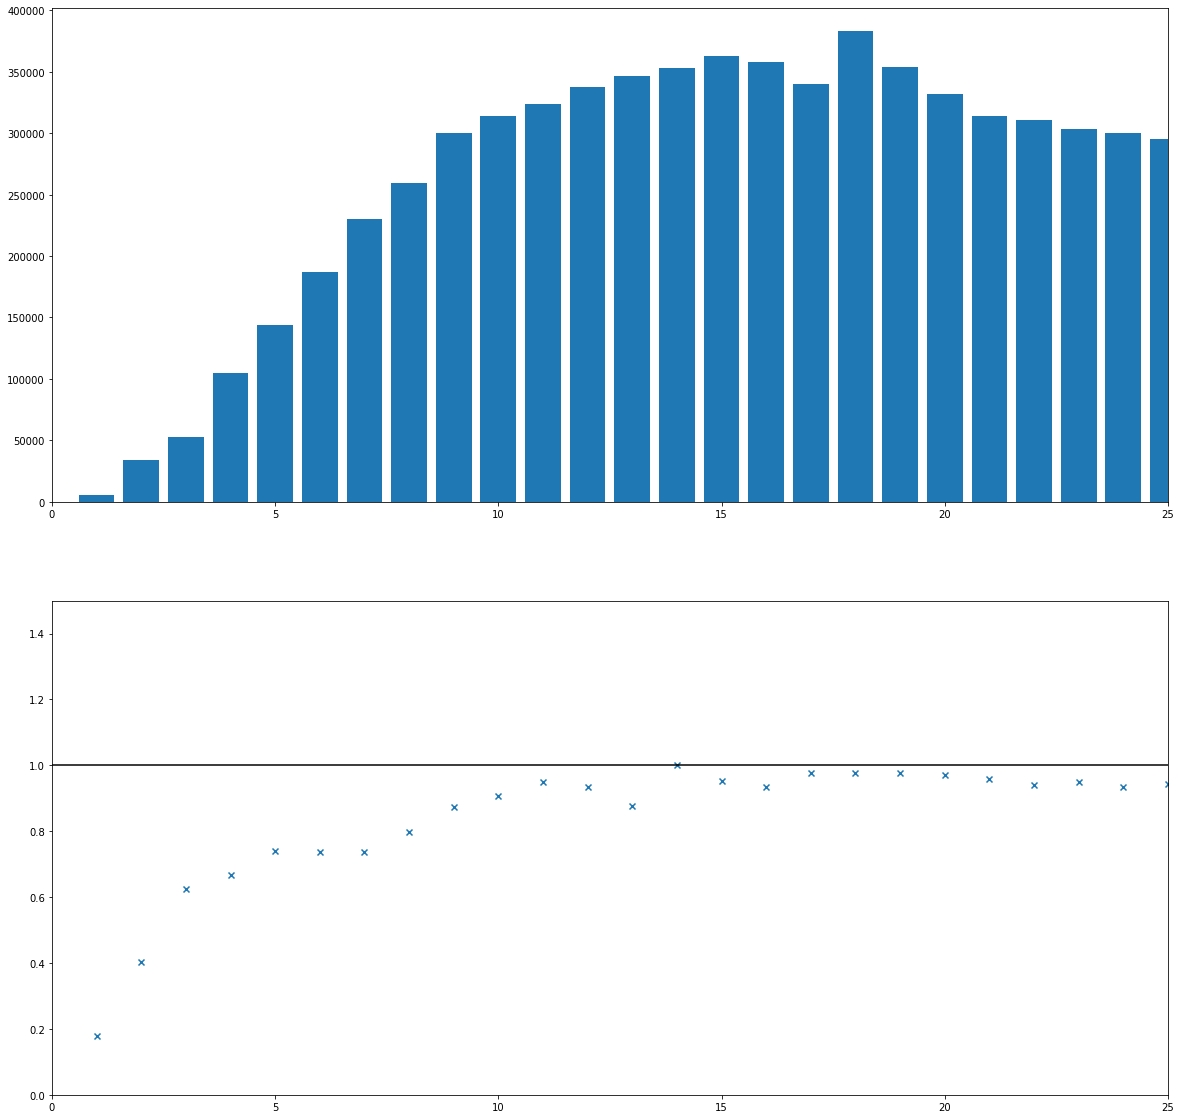

In [29]:
# plot combined histogram by taking euclidean distance to compute lag scalar
total_bins_count = vario_ana.total_bins_count
total_bins = vario_ana.total_bins
total_res = vario_ana.total_res

cutoff = 25
error_var = 0

fig, axs = plt.subplots(2,1, figsize=(20,20))
axs[0].bar(np.arange(len(total_bins_count[:cutoff,0]))+1, total_bins_count[:cutoff,error_var])
axs[0].set_xlim((0,len(total_bins[:cutoff])))
axs[1].scatter(total_res*(np.arange(len(total_bins_count[:cutoff,0]))+1), total_bins[:cutoff,error_var], marker="x")
axs[1].set_xlim((0,len(total_bins[:cutoff])*total_res))
axs[1].plot(total_res*np.arange(len(total_bins[:cutoff])+1), np.full(len(total_bins[:cutoff])+1, 1), color="k")
axs[1].set_ylim([0,1.5])
plt.show()

# export data for fitting test
x = total_res*(np.arange(len(total_bins_count[:cutoff,0]))+1)
y = total_bins[:cutoff,0]
variogram_pts = pd.DataFrame({"lag":x, "semivariance":y})
variogram_pts.to_csv("/home/jonas/Downloads/variogram_pts.csv", index_label=False)

## Sanity Check to Verify VariogramAnalysis class works

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


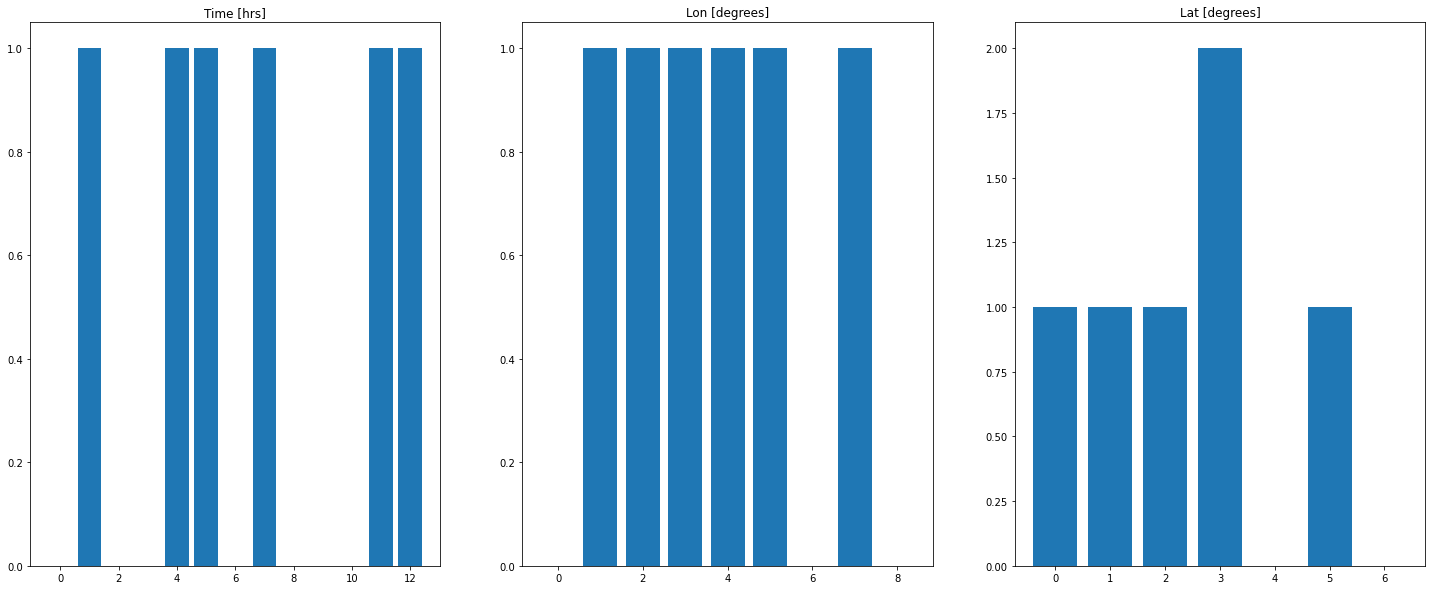

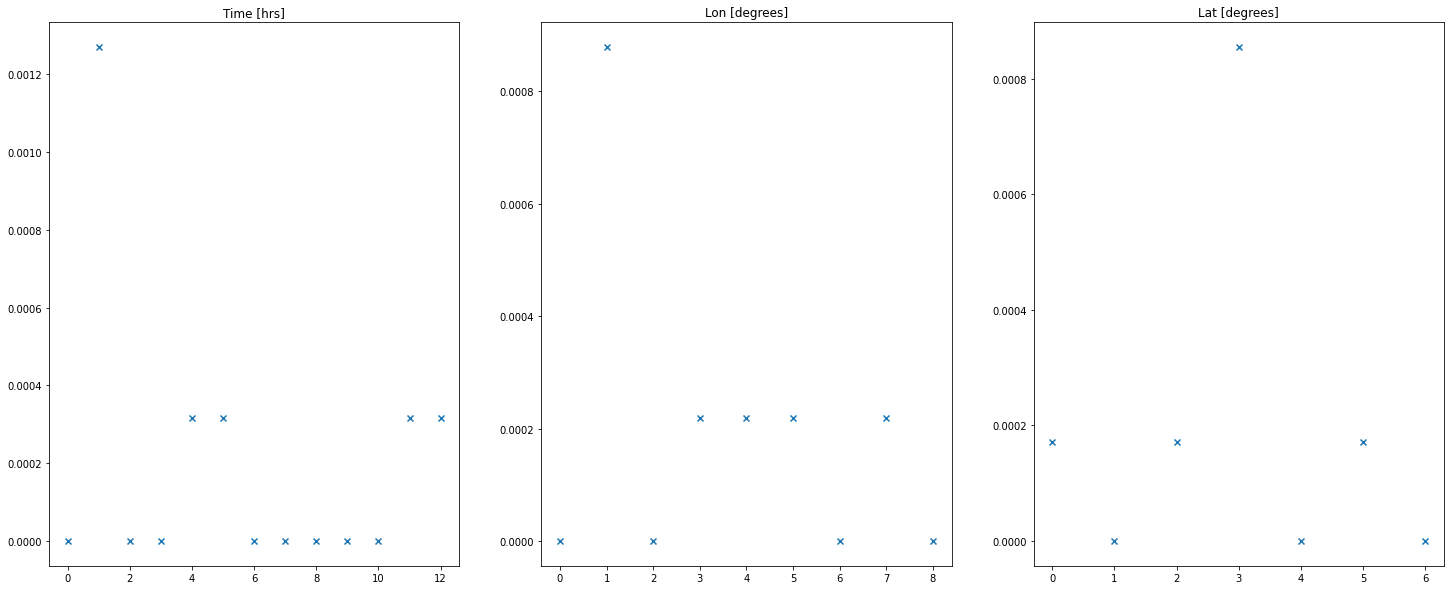

In [7]:
%load_ext autoreload
%autoreload 2

# Note for easier analysis comment out the division at the end of the function

from variogram.VariogramAnalysis import VariogramAnalysis

from datetime import datetime
import pandas as pd

# define toy values for all cols
time = [datetime(2022,5,5,13), datetime(2022,5,6,1), datetime(2022,5,5,14), datetime(2022,5,5,18)]
# t_lag = [12, 1, 5, 11, 7, 4]
lon = [-130.5, -124.6, -132.1, -127.3]
# lon_lag = [5, 1, 3, 7, 2, 4]
lat = [25.2, 27.6, 22.1, 25.8]
# lat_lag = [2, 3, 0, 5, 1, 3]
u_error = [0.3, 0.5, 0.7, 0.5]
# u_squared_diff = [0.04, 0.16, 0.04, 0.04, 0.0, 0.04]
v_error = [0.3, 0.7, 0.5, 0.5]
# v_squared_diff = [0.16, 0.04, 0.04, 0.04, 0.4, 0.0]
buoy = ["1", "2", "3", "1"]

# create dataset
toy_example = {"time":time, "lon":lon, "lat":lat, "u_error":u_error, "v_error":v_error, "buoy":buoy}
data = pd.DataFrame(toy_example)

vario_ana = VariogramAnalysis(data)
vario_ana.build_variogram_gen((1,1,1), 25, chunk_size=3, detrended=False, cross_buoy_pairs_only=False)
vario_ana.plot_histograms()
vario_ana.plot_variograms("u")

## Exploring detrending

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


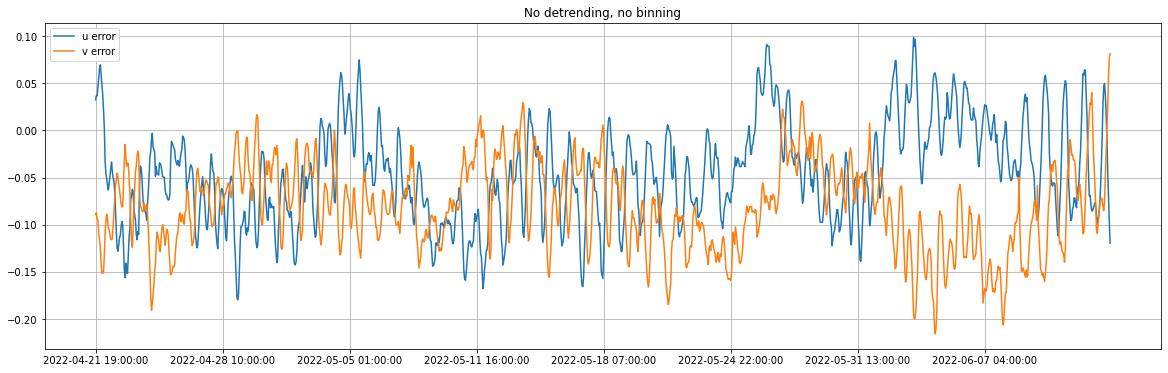

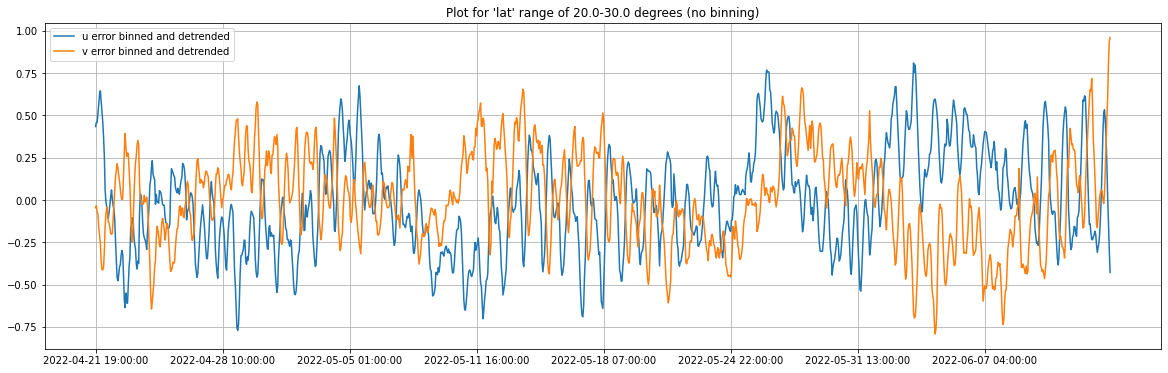

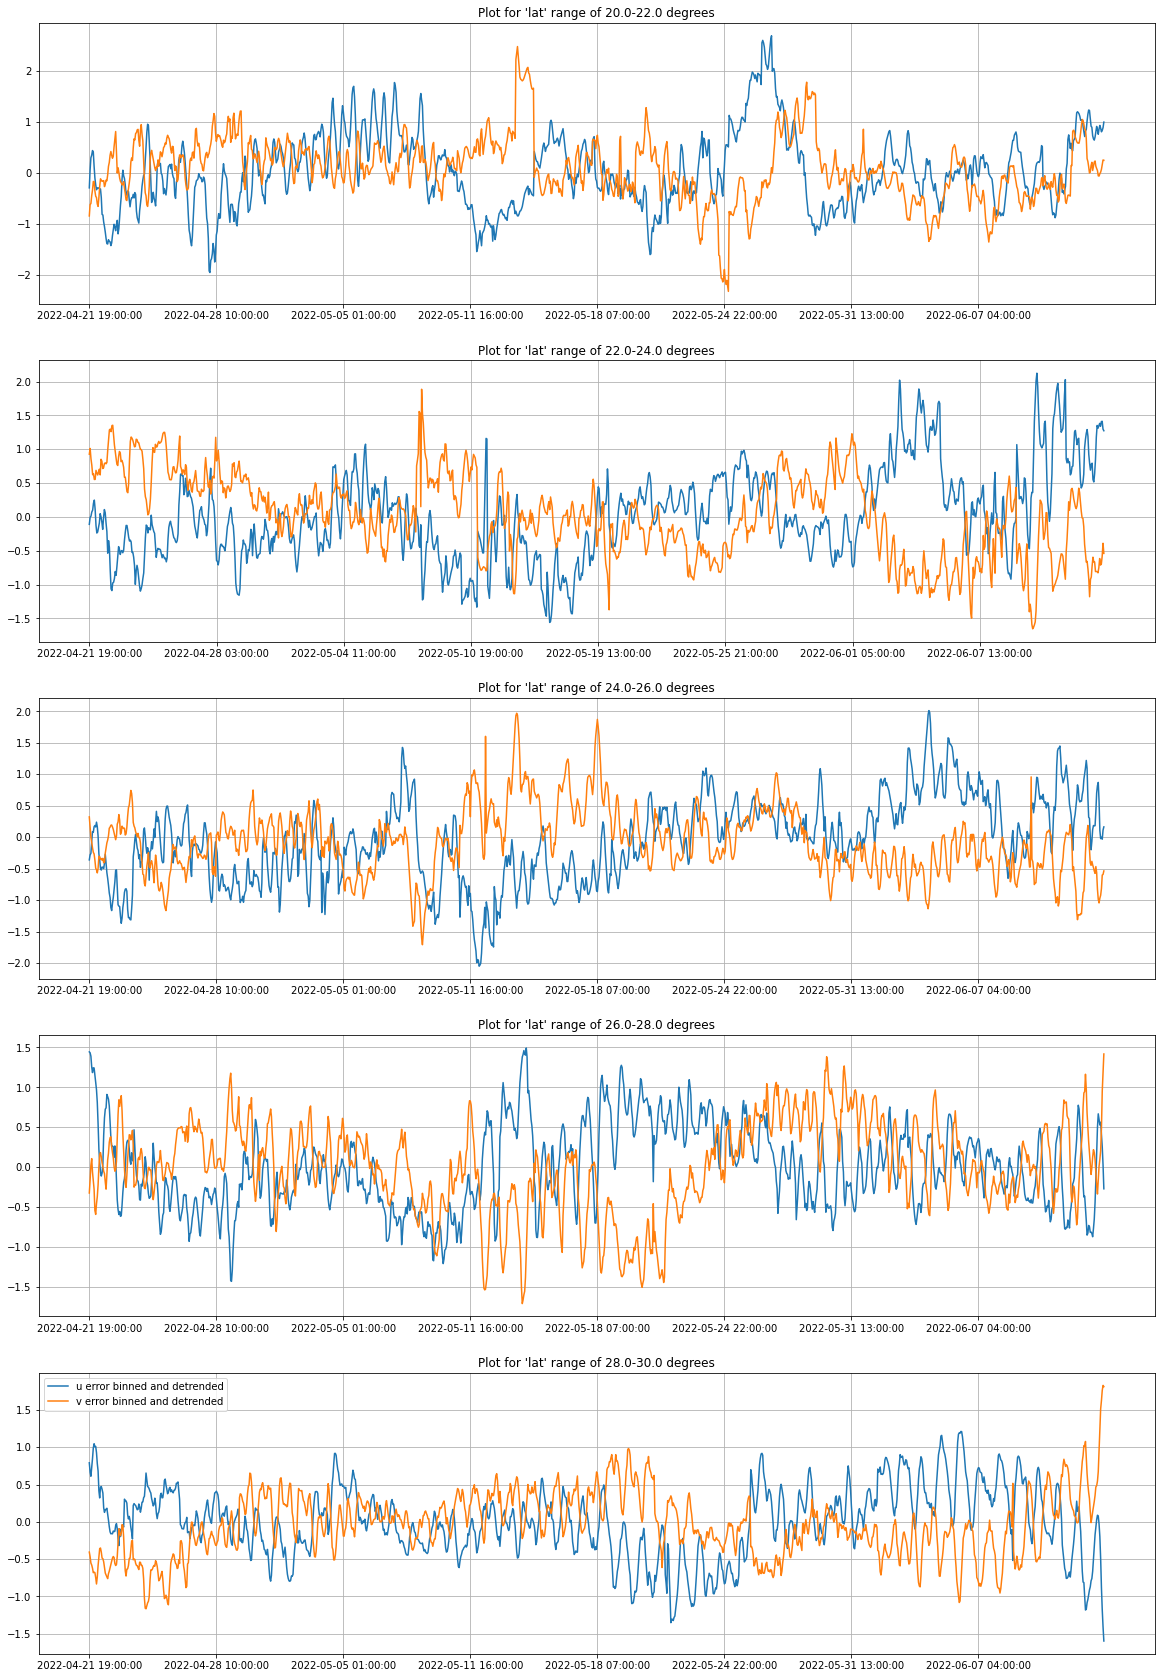

In [7]:
%load_ext autoreload
%autoreload 2

from generative_model_metrics import calc_speed_mean, calc_speed_RMSE
from variogram.VariogramAnalysis import VariogramAnalysis
from Dataset import load_test_data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# load 40 days worth of data
df = load_test_data()
var_ana = VariogramAnalysis(df)

# plotting RMSE without detrending and binning
df["RMSE"] = np.sqrt(df["u_error"]**2 + df["v_error"]**2)
df_group = df.groupby(by=["time"], as_index=False).mean()
fig, ax = plt.subplots(figsize=(20,6))
# plt.plot(df_group["time"], df_group["RMSE"], label="RMSE")
plt.plot(df_group["time"], df_group["u_error"], label="u error")
plt.plot(df_group["time"], df_group["v_error"], label="v error")
plt.xticks(np.arange(0, len(df_group), round(len(df_group)/8)))
plt.title("No detrending, no binning")
plt.legend()
plt.grid()
plt.show()

# detrended without binning
var_ana.detrend(detrend_var="lat", num_bins=1)
var_ana.plot_detrended_bins()

# detrended with binning
var_ana.detrend(detrend_var="lat", num_bins=5)
var_ana.plot_detrended_bins()

## Detrending Plots in 3D

 - still bin data by e.g. `lat`
 - no group by time to produce -> group by [`lon`, `lat`]

In [1]:
%load_ext autoreload
%autoreload 2

from generative_model_metrics import calc_speed_mean, calc_speed_RMSE
from variogram.VariogramAnalysis import VariogramAnalysis
from Dataset import load_test_data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# load 40 days worth of data
df = load_test_data()

lon = np.arange(20)
lat = np.arange(10)
# use meshgrid to define domain
lonv, latv = np.meshgrid(lon, lat)
print(lonv)

# TODO: visualise in 3D by summing over time

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]]


## Scikit-GStat package

loaded: copernicus_forecast_error_lon_[-140, -120]_lat_[20.0, 30.0]_time_2022-05-22T18:30:00Z__2022-05-31T17:30:00Z.csv


/home/jonas/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[  7.15847258  14.31694516  21.47541775  28.63389033  35.79236291
  42.95083549  50.10930807  57.26778066  64.42625324  71.58472582
  78.7431984   85.90167099  93.06014357 100.21861615 107.37708873
 114.53556131 121.6940339  128.85250648 136.01097906 143.16945164
 150.32792422 157.48639681 164.64486939 171.80334197 178.96181455
 186.12028713 193.27875972 200.4372323  207.59570488 214.75417746] [0.01915478 0.02517186 0.02640726 0.0259946  0.026459   0.0269004
 0.02750665 0.02792771 0.02861863 0.02918455 0.02949511 0.03028283
 0.03037118 0.029384   0.02894768 0.02850101 0.02749985 0.02615538
 0.02572459 0.02605693 0.02629842 0.02725592 0.02816277 0.02845742
 0.0291552  0.03063292 0.03204195 0.03092128 0.02757818 0.02349793] <bound method Variogram.data of < spherical Semivariogram fitted to 30 bins >>


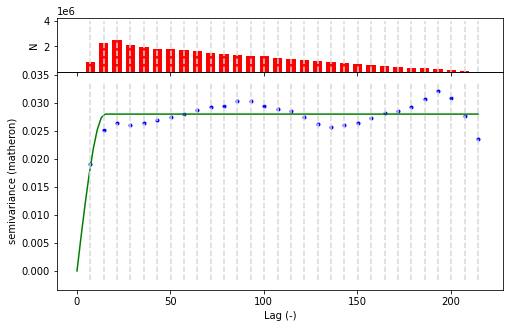

In [7]:
# use existing SciKit-GStat package
from Dataset import load_single_file
import skgstat as skg
data = load_single_file(0)

# convert time axis to datetime
data["time"] = pd.to_datetime(data["time"])

# find earliest time/date and subtract from time column
earliest_date = data["time"].min()
data["time_offset"] = data["time"].apply(lambda x: (x - earliest_date).seconds//3600 + (x-earliest_date).days*24)

coordinates = np.hstack([np.array(data["time_offset"]).reshape(-1,1), np.array(data["lon"]).reshape(-1,1), np.array(data["lat"]).reshape(-1,1)])
values = np.array([data["u_error"]]).reshape(-1)

# the SpaceTimeVariogram to work we need values of (m, n) with m being the coordinates dimension and n the time dimension
V = skg.Variogram(coordinates, values, dist_func="euclidean", bin_func="even", n_lags=30)
V.plot()
print(V.bins, V.experimental, V.data)

This looks very similar to the shape produced by the 1D variogram produced with my own code!

# Using Geostatspy for 2D

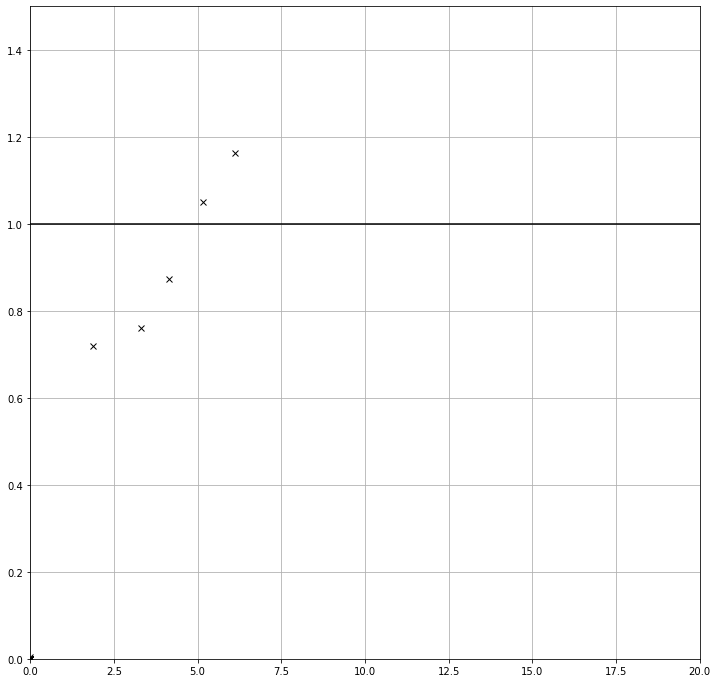

In [20]:
# set params
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = 2.0; lag_tol = 4.0; nlag = 20;               # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 22.5                             # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [0, 90]                                       # directions in azimuth to consider

lag, gamma, npp = geostats.gamv(
    data,
    "lon",
    "lat",
    "u_error",
    tmin,
    tmax,
    lag_dist,
    lag_tol,
    nlag,
    azi_mat[0],
    atol,
    bandh,
    isill
)

fig = plt.figure(figsize=(12,12))
plt.plot(lag, gamma, 'x', color = 'black')
plt.plot([0,20], [1.0, 1.0], color = 'black')
plt.xlim([0, 20])
plt.ylim([0, 1.5])
plt.grid(True)
plt.show()